In [147]:
! pip install -qU langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python gpt4all firecrawl-py llama-parse nest-asyncio langchain-text-splitters pypdf langchain-groq unstructured

In [148]:
import os
from google.colab import userdata

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')
os.environ['LLAMA_CLOUD_API_KEY'] = userdata.get('LLAMA_CLOUD_API_KEY')
os.environ['FIRECRAW_KEY'] = userdata.get('FIRECRAW_KEY')
os.environ['GROQ_KEY'] = userdata.get('GROQ_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [150]:
import nest_asyncio
nest_asyncio.apply()


In [151]:
from llama_parse import LlamaParse

# Initialize LlamaParse
parser = LlamaParse(
    api_key=os.getenv('LLAMA_CLOUD_API_KEY'),
    result_type="markdown",  # or "text"
    num_workers=4,
    verbose=True,
    language="en"
)


In [152]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [153]:
from langchain_community.document_loaders import DirectoryLoader

directory_path = r""  # <------------ SELECIONE O DIRETORIO

#def load_documents_from_directory(directory):
#    documents = parser.load_data(directory)
#    return documents

# Load documents from the specified directory
# local_documents = load_documents_from_directory(directory_path)

# DOCUMENTAÇÂO PARA document_loaders
# https://python.langchain.com/v0.1/docs/modules/data_connection/document_loaders/file_directory/
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

loader = DirectoryLoader(directory_path, glob="**/*.txt", show_progress=True)
local_documents = loader.load()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!

100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


INDEX arquivos

In [157]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,  # Adjust as needed
    chunk_overlap=200  # Overlap for better context
)

# Split the loaded documents
doc_splits = text_splitter.split_documents(local_documents)

In [158]:
from langchain.schema import Document

# Filter and clean documents
filtered_docs = [
    Document(page_content=doc.page_content, metadata=doc.metadata)
    for doc in doc_splits if isinstance(doc, Document)
]


In [159]:
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings

# Initialize the vector store
vectorstore = Chroma.from_documents(
    documents=filtered_docs,
    collection_name="rag-chroma",
    embedding=GPT4AllEmbeddings(),
)


In [160]:
# Initialize the retriever
retriever = vectorstore.as_retriever()

# Example query
query = "Explain the RISC-V architecture"

# Retrieve relevant documents
results = retriever.get_relevant_documents(query)

# Print the results
for idx, result in enumerate(results, start=1):
    print(f"Result {idx}:\n{result.page_content}\n{'-'*80}")

Result 1:
RISC-V
--------------------------------------------------------------------------------
Result 2:
051. **[^](#cite_ref-54 "Jump up")**RISC-V Platform Horizontal Subcommittee (December 2021). ["RISC-V Platform Specification"](https://github.com/riscv/riscv-platform-specs/blob/main/riscv-platform-spec.pdf)(PDF). Version 0.3-draft.
--------------------------------------------------------------------------------
Result 3:
- ["RISC-V Assembly Language Programming"](https://github.com/johnwinans/rvalp). _GitHub_. 8 November 2019.
- Waterman, Andrew (January 2016). ["Design of the RISC-V Instruction Set Architecture"](https://www2.eecs.berkeley.edu/Pubs/TechRpts/2016/EECS-2016-1.pdf)(PDF). _EECS Department, University of California, Berkeley_. EECS-2016-1.
--------------------------------------------------------------------------------
Result 4:
RISC-V was begun with a goal to make a practical ISA that was open-sourced, usable academically, and deployable in any hardware or software

In [164]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain.docstore.document import Document
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import FireCrawlLoader

# Diretório contendo os documentos locais
directory_path = r"" # <--------------- SELECIONAR O DIRETORIO

# Função para carregar os documentos do diretório
def load_documents_from_directory(directory):
    loader = DirectoryLoader(directory)
    documents = loader.load()
    return documents

# Carregar os documentos do diretório
local_documents = load_documents_from_directory(directory_path)

# URLs de onde os documentos são extraídos via scraping
urls = [
    #"https://riscv-programming.org/book/riscv-book.html"
    "https://en.wikipedia.org/wiki/RISC-V" # < ----------------- MODIFICAR
]

# Função para carregar os documentos das URLs
docs_from_urls = [FireCrawlLoader(api_key=os.getenv('FIRECRAW_KEY'), url=url, mode="scrape").load() for url in urls]

# Unir documentos locais e documentos das URLs
all_docs = local_documents + [item for sublist in docs_from_urls for item in sublist]

# Split (divisão) dos documentos
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

doc_splits = text_splitter.split_documents(all_docs)

# Filtrar metadata e garantir formatação adequada
filtered_docs = []
for doc in doc_splits:
    if isinstance(doc, Document) and hasattr(doc, 'metadata'):
        clean_metadata = {k: v for k, v in doc.metadata.items() if isinstance(v, (str, int, float, bool))}
        filtered_docs.append(Document(page_content=doc.page_content, metadata=clean_metadata))

# Adicionar ao vectorDB
vectorstore = Chroma.from_documents(
    documents=filtered_docs,
    collection_name="rag-chroma",
    embedding=GPT4AllEmbeddings(),
)

# Definir o retriever a partir do vectorstore
retriever = vectorstore.as_retriever()


GRADE DOCUMENTS

In [165]:
from langchain_groq import ChatGroq
from langchain_community.chat_models import ChatOllama

# LLM
#llm = ChatOllama(model=local_llm, format="json", temperature=0)
# Aqui eu mudei para usar uma LLM de uma api externa utilizando o GROQ
llm = ChatGroq(temperature=0, groq_api_key=os.getenv('GROQ_KEY'), model_name="llama-3.1-70b-versatile")


In [168]:
# Retrival Grader
from langchain_groq import ChatGroq
from langchain_community.chat_models import ChatOllama
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# Criação do template de prompt para avaliação da relevância de documentos
prompt = PromptTemplate(
    template="""
    <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
    Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question.
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document:
    \n\n {document} \n\n
    Here is the user question: {question} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"]
)

# Combina o prompt, o modelo de linguagem e o parser para output JSON
retrieval_grader = prompt | llm | JsonOutputParser()

# Exemplo de pergunta do usuário
question = "Qual é o método mais eficiente para implementar em RISC-V?"

# Recupera documentos com base na pergunta
docs = retriever.invoke(question)

# Pega o conteúdo do segundo documento recuperado
doc_txt = docs[1].page_content

# Avalia a relevância do documento e imprime o resultado
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))


{'score': 'yes'}


In [166]:
doc_txt

'Logo do conjunto de instruções\n\nRISC-V\n\nPlaca de desenvolvimento que\n\nintegra RISC-V\n\nRISC-V\n\nRISC-V é um conjunto de instruções (ISA) baseado em princípios\n\nRISC  (acrônimo  de  Reduced  Instruction  Set  Computing,  em\n\nportuguês, “Computação de conjunto de instruções reduzidas”).\n\nRISC-V  é  livre  para  ser  usado  para  qualquer  finalidade,\n\npermitindo a qualquer pessoa ou empresa projetar e vender chips e\n\nsoftware RISC-V sem precisar pagar royalties.\n\nEmbora não seja o primeiro conjunto de instruções livre, ele é\n\nimportante  porque  foi  projetado  com  foco  para  dispositivos'

Generate Answer

In [167]:
# Generate answer
from langchain.prompts import PromptTemplate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""
    <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question}
    Context: {context}
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "context"]
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "Qual é o método mais eficiente para implementar em RISC-V?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)


O método mais eficiente para implementar em RISC-V não é especificado no contexto fornecido. No entanto, o RISC-V foi projetado para implementações de alto desempenho e baixo consumo de energia.


Pesquisa tavly

In [169]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)


### Hallucination Grader

In [170]:
# Prompt
prompt = PromptTemplate(
    template="""
    <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' score to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n -------- \n
    {documents}
    \n -------- \n
    Here is the answer: {generation} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"]
)

# Criação do Hallucination Grader
hallucination_grader = prompt | llm | JsonOutputParser()

# Execução do Hallucination Grader
hallucination_grader.invoke({"documents": docs, "generation": generation})


{'score': 'yes'}

### Answer Grader

In [171]:
# Prompt
prompt = PromptTemplate(
    template="""
    <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n -------- \n
    {generation}
    \n -------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"]
)

# Criação do Answer Grader
answer_grader = prompt | llm | JsonOutputParser()

# Execução do Answer Grader
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'no'}

Lang Graph - Setup states & nodes

In [172]:
from typing_extensions import TypedDict
from typing import List
from langchain.schema import Document

### State

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("----RETRIEVE----")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    If any document is not relevant, we will set a flag to run web search.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("----CHECK DOCUMENT RELEVANCE TO QUESTION----")
    question = state["question"]
    documents = state["documents"]

    # Score each document
    filtered_docs = []
    web_search = "No"

    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score["score"]

        # Document relevant
        if grade.lower() == "yes":
            print("----GRADE: DOCUMENT RELEVANT----")
            filtered_docs.append(d)

        # Document not relevant
        else:
            print("----GRADE: DOCUMENT NOT RELEVANT----")
            # We do not include the document in filtered_docs

    # Update state with the filtered documents
    if len(filtered_docs) == 0:
        web_search = "Yes"  # If no document is relevant, set flag to perform web search

    return {"filtered_docs": filtered_docs, "web_search": web_search}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    print("----GENERATE----")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def web_search(state):
    """
    Web search based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("----WEB SEARCH----")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]

    return {"documents": documents, "question": question}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("----ASSESS GRADED DOCUMENTS----")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # Todos os documentos foram filtrados como irrelevantes
        # Vamos gerar uma nova consulta
        print("----DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH----")
        return "websearch"

    else:
        # Temos documentos relevantes, então geramos a resposta
        print("----DECISION: WE HAVE RELEVANT DOCUMENTS, SO GENERATE ANSWER----")
        return "generate"

### Conditional edge

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    print("----CHECK HALLUCINATIONS----")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("----DECISION: GENERATION IS GROUNDED IN DOCUMENTS----")
        # Check question-answering
        print("----GRADE GENERATION vs QUESTION----")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]

        if grade == "yes":
            print("----DECISION: GENERATION ADDRESSES QUESTION----")
            return "useful"
        else:
            print("----DECISION: GENERATION DOES NOT ADDRESS QUESTION----")
            return "not useful"
    else:
        print("----DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY----")
        return "not supported"

In [173]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # gener

In [174]:
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",   #loop2
        "useful": END,
        "not useful": "websearch",  # loop3
    },
)

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)

workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)


In [175]:
app = workflow.compile()

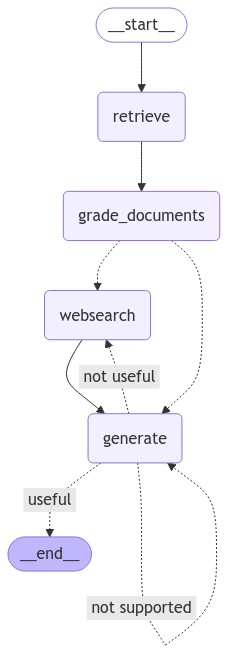

In [180]:
# Exibir o grafo como uma imagem gerada (Mermaid diagram)
from IPython.display import Image

# Gera a imagem do grafo usando Mermaid
display(Image(app.get_graph(xray=True).draw_mermaid_png()))


In [176]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint
inputs = {"question": "Qual é o método mais eficiente para implementar em RISC-V?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")

print(value["generation"])


----RETRIEVE----
'Finished running: retrieve:'
----CHECK DOCUMENT RELEVANCE TO QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ASSESS GRADED DOCUMENTS----
----DECISION: WE HAVE RELEVANT DOCUMENTS, SO GENERATE ANSWER----
'Finished running: grade_documents:'
----GENERATE----
----CHECK HALLUCINATIONS----
----DECISION: GENERATION IS GROUNDED IN DOCUMENTS----
----GRADE GENERATION vs QUESTION----
----DECISION: GENERATION DOES NOT ADDRESS QUESTION----
'Finished running: generate:'
----WEB SEARCH----
'Finished running: websearch:'
----GENERATE----
----CHECK HALLUCINATIONS----
----DECISION: GENERATION IS GROUNDED IN DOCUMENTS----
----GRADE GENERATION vs QUESTION----
----DECISION: GENERATION ADDRESSES QUESTION----
'Finished running: generate:'
O método mais eficiente para implementar em RISC-V é baseado em uma abordagem simplificada, focada em um conjunto reduzido de instruções, o que a torna mai